<a href="https://colab.research.google.com/github/Pam-Pam29/Formative-2-Multimodal-Data-Preprocessing/blob/main/models%20/Complete_Audio_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 3: Sound Data Collection and Processing

## Assignment Requirements

This notebook completes the audio processing part of the assignment:

1. Load and display sound samples as **waveforms** and **spectrograms** for each member
2. Apply **at least 2 augmentations** per sample (pitch shift, time stretch, background noise)
3. Extract features: **MFCCs**, **spectral roll-off**, and **energy**
4. Save features to `audio_features.csv`

## Your Setup
- 6 audio files ready to process


## Step 1: Install and Import Libraries


In [1]:
import librosa
import librosa.display
import soundfile as sf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
import subprocess
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

print(" All libraries installed and imported successfully!")


 All libraries installed and imported successfully!


## Step 2: Load Audio Files from GitHub


In [2]:
GITHUB_REPO = 'https://github.com/Pam-Pam29/Formative-2-Multimodal-Data-Preprocessing'
BRANCH = 'main'
AUDIO_DIR_PATH = 'data/audio_samples'
WORKING_DIR = 'audio_files'

if os.path.exists('Formative-2-Multimodal-Data-Preprocessing'):
    shutil.rmtree('Formative-2-Multimodal-Data-Preprocessing')

subprocess.run(['git', 'clone', GITHUB_REPO], check=True)

os.makedirs(WORKING_DIR, exist_ok=True)

source_dir = os.path.join('Formative-2-Multimodal-Data-Preprocessing', AUDIO_DIR_PATH)
if os.path.exists(source_dir):
    for file in os.listdir(source_dir):
        src = os.path.join(source_dir, file)
        if os.path.isfile(src):
            shutil.copy2(src, WORKING_DIR)

def find_audio_files(directory=WORKING_DIR):
    audio_extensions = ['.wav', '.mp3', '.flac', '.m4a', '.ogg', '.WAV', '.MP3']
    audio_files = []
    for ext in audio_extensions:
        audio_files.extend(Path(directory).glob(f'*{ext}'))
    return sorted(audio_files)

audio_files = find_audio_files()
print(f"\n Audio files ready for processing: {len(audio_files)}")
for f in audio_files:
    print(f"  - {f.name}")



 Audio files ready for processing: 6
  - Pam_Confirm transaction.wav
  - Pam_Yes approve .wav
  - Rele_Recording_1.m4a
  - Rele_Recording_2.m4a
  - dennis_approve.wav
  - dennis_confirm.wav


## Step 3: Load and Display Audio Files


Loaded: Pam_Confirm transaction.wav
Sample rate: 22050 Hz, Duration: 2.65 seconds


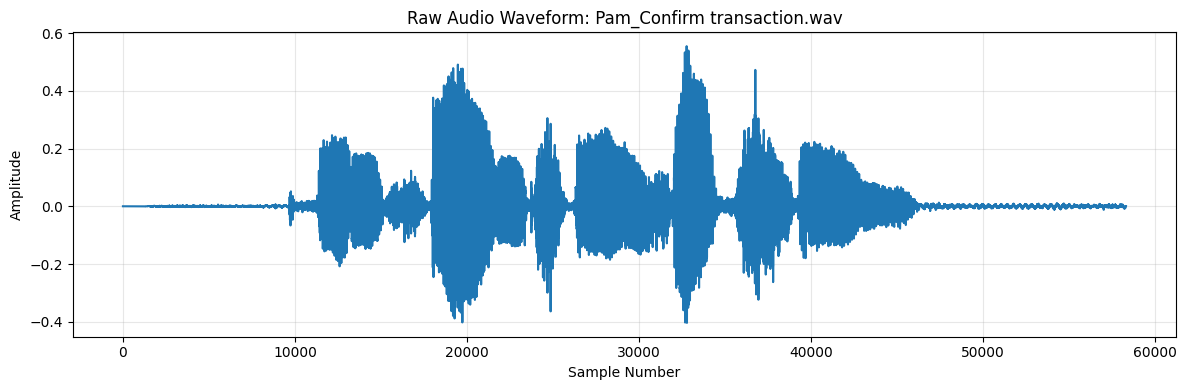

In [3]:
if len(audio_files) > 0:
    audio_path = str(audio_files[0])
    y, sr = librosa.load(audio_path)
    print(f"Loaded: {Path(audio_path).name}")
    print(f"Sample rate: {sr} Hz, Duration: {len(y)/sr:.2f} seconds")

    plt.figure(figsize=(12, 4))
    pd.Series(y).plot()
    plt.title(f'Raw Audio Waveform: {Path(audio_path).name}')
    plt.xlabel('Sample Number')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


## Step 4: Trimming Audio Signal


Original: 2.65s, Trimmed: 1.63s


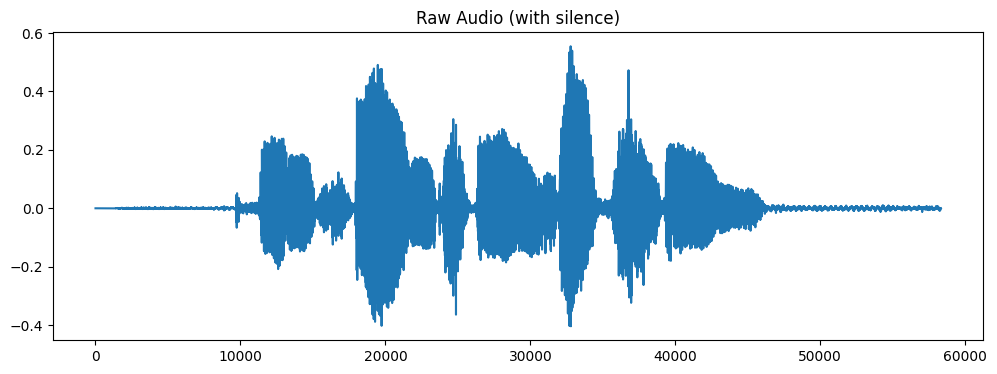

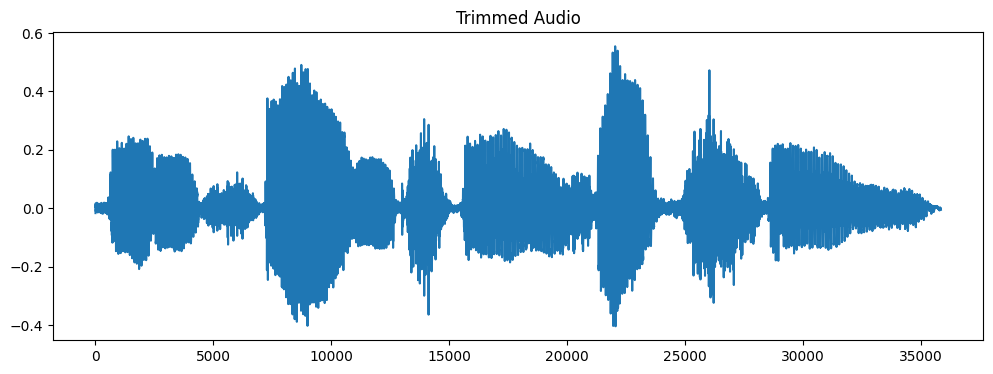

In [4]:
if len(audio_files) > 0:
    audio_path = str(audio_files[0])
    y, sr = librosa.load(audio_path)
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)
    print(f"Original: {len(y)/sr:.2f}s, Trimmed: {len(y_trimmed)/sr:.2f}s")

    plt.figure(figsize=(12, 4))
    pd.Series(y).plot(title='Raw Audio (with silence)')
    plt.show()

    plt.figure(figsize=(12, 4))
    pd.Series(y_trimmed).plot(title='Trimmed Audio')
    plt.show()


## Step 5: Waveform to Spectrogram


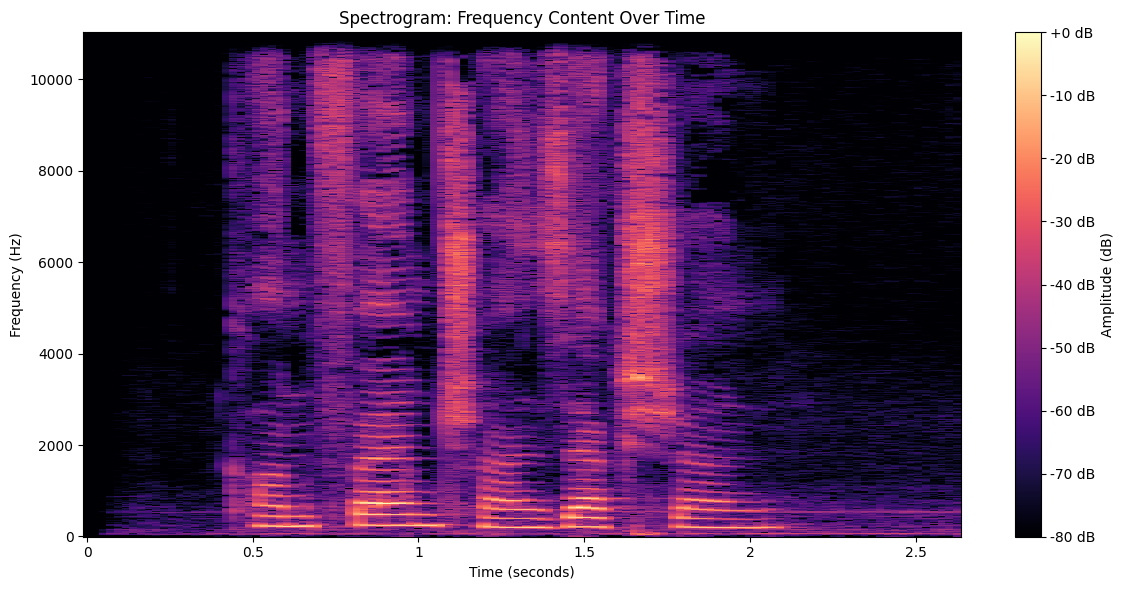

In [5]:
if len(audio_files) > 0:
    audio_path = str(audio_files[0])
    y, sr = librosa.load(audio_path)
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    plt.figure(figsize=(12, 6))
    librosa.display.specshow(S_db, y_axis='hz', x_axis='time', sr=sr)
    plt.colorbar(format='%+2.0f dB', label='Amplitude (dB)')
    plt.title('Spectrogram: Frequency Content Over Time')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (seconds)')
    plt.tight_layout()
    plt.show()


## Step 6: Mel Spectrogram


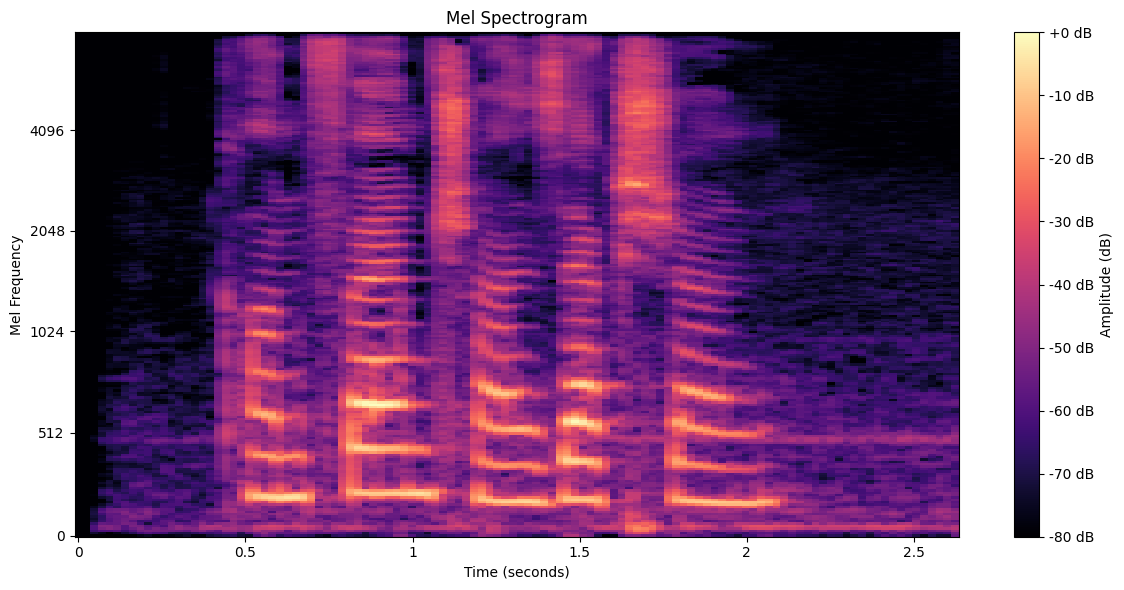

In [6]:
if len(audio_files) > 0:
    audio_path = str(audio_files[0])
    y, sr = librosa.load(audio_path)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128 * 2)
    S_db_mel = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(12, 6))
    librosa.display.specshow(S_db_mel, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
    plt.colorbar(format='%+2.0f dB', label='Amplitude (dB)')
    plt.title('Mel Spectrogram')
    plt.ylabel('Mel Frequency')
    plt.xlabel('Time (seconds)')
    plt.tight_layout()
    plt.show()


## Step 7: Feature Extraction and Augmentation

Next, we'll:
1. Define feature extraction functions (MFCCs, spectral roll-off, energy)
2. Define augmentation functions (pitch shift, time stretch, noise)
3. Process all audio files with visualizations and feature extraction


## Step 8: Define Feature Extraction Functions

### Function 1: MFCC Features


In [7]:
def extract_mfcc_features(audio, sr, n_mfcc=13):
    """Extract MFCC features"""
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return {
        'mfcc_mean': np.mean(mfccs, axis=1),
        'mfcc_std': np.std(mfccs, axis=1),
        'mfcc_max': np.max(mfccs, axis=1),
        'mfcc_min': np.min(mfccs, axis=1)
    }

print(" MFCC extraction function defined")


 MFCC extraction function defined


### Function 2: Spectral Features (including roll-off)


In [8]:
def extract_spectral_features(audio, sr):
    """Extract spectral features including roll-off"""
    features = {}
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    features['spectral_rolloff_mean'] = np.mean(rolloff)
    features['spectral_rolloff_std'] = np.std(rolloff)
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    features['spectral_centroid_mean'] = np.mean(centroid)
    features['spectral_centroid_std'] = np.std(centroid)
    bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    features['spectral_bandwidth_mean'] = np.mean(bandwidth)
    features['spectral_bandwidth_std'] = np.std(bandwidth)
    return features

print(" Spectral features extraction function defined")


 Spectral features extraction function defined


### Function 3: Energy Features


In [9]:
def extract_energy_features(audio):
    """Extract energy features"""
    features = {}
    rms = librosa.feature.rms(y=audio)
    features['rms_energy_mean'] = np.mean(rms)
    features['rms_energy_std'] = np.std(rms)
    features['rms_energy_max'] = np.max(rms)
    zcr = librosa.feature.zero_crossing_rate(audio)
    features['zcr_mean'] = np.mean(zcr)
    features['zcr_std'] = np.std(zcr)
    return features

print(" Energy features extraction function defined")


 Energy features extraction function defined


### Function 4: Chroma Features


In [10]:
def extract_chroma_features(audio, sr):
    """Extract chroma features"""
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    return {
        'chroma_mean': np.mean(chroma, axis=1),
        'chroma_std': np.std(chroma, axis=1)
    }

print(" Chroma features extraction function defined")


 Chroma features extraction function defined


### Main Function: Combine All Features


In [11]:
def extract_all_features(audio_path):
    """Extract ALL features by combining all individual functions"""
    audio, sr = librosa.load(audio_path, sr=None)
    features = {}

    mfcc_data = extract_mfcc_features(audio, sr)
    for i in range(len(mfcc_data['mfcc_mean'])):
        features[f'mfcc_mean_{i}'] = mfcc_data['mfcc_mean'][i]
        features[f'mfcc_std_{i}'] = mfcc_data['mfcc_std'][i]
        features[f'mfcc_max_{i}'] = mfcc_data['mfcc_max'][i]
        features[f'mfcc_min_{i}'] = mfcc_data['mfcc_min'][i]

    spectral_features = extract_spectral_features(audio, sr)
    features.update(spectral_features)

    energy_features = extract_energy_features(audio)
    features.update(energy_features)

    chroma_data = extract_chroma_features(audio, sr)
    for i in range(len(chroma_data['chroma_mean'])):
        features[f'chroma_mean_{i}'] = chroma_data['chroma_mean'][i]
        features[f'chroma_std_{i}'] = chroma_data['chroma_std'][i]

    features['duration'] = len(audio) / sr
    features['sample_rate'] = sr
    features['max_amplitude'] = np.max(np.abs(audio))
    features['mean_amplitude'] = np.mean(np.abs(audio))

    return features

print(" Main function ready - combines all feature extraction functions")


 Main function ready - combines all feature extraction functions


## Step 9: Define Augmentation Functions


In [12]:
def augment_pitch_shift(audio, sr, n_steps=2):
    """Shift pitch up or down"""
    return librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=n_steps)

def augment_time_stretch(audio, rate=1.2):
    """Stretch or compress time"""
    return librosa.effects.time_stretch(y=audio, rate=rate)

def augment_add_noise(audio, noise_factor=0.005):
    """Add random noise"""
    noise = np.random.randn(len(audio))
    return audio + noise_factor * noise

def augment_speed_change(audio, speed_factor=1.1):
    """Change playback speed"""
    return librosa.effects.time_stretch(y=audio, rate=speed_factor)

print(" Augmentation functions defined!")


 Augmentation functions defined!


## Step 10: Process ALL Audio Files

This will process ALL 6 audio files, showing visualizations for each and extracting features.


PROCESSING ALL AUDIO FILES
This will process ALL audio files and show visualizations for EACH one

Found 6 audio file(s) to process
Each file will have:
  - Waveform visualization
  - Spectrogram visualization
  - Features extracted (original + 8 augmentations)


PROCESSING FILE 1 of 6: Pam_Confirm transaction
Sample rate: 48000 Hz | Duration: 2.65 seconds

[1/6] Displaying waveform for: Pam_Confirm transaction


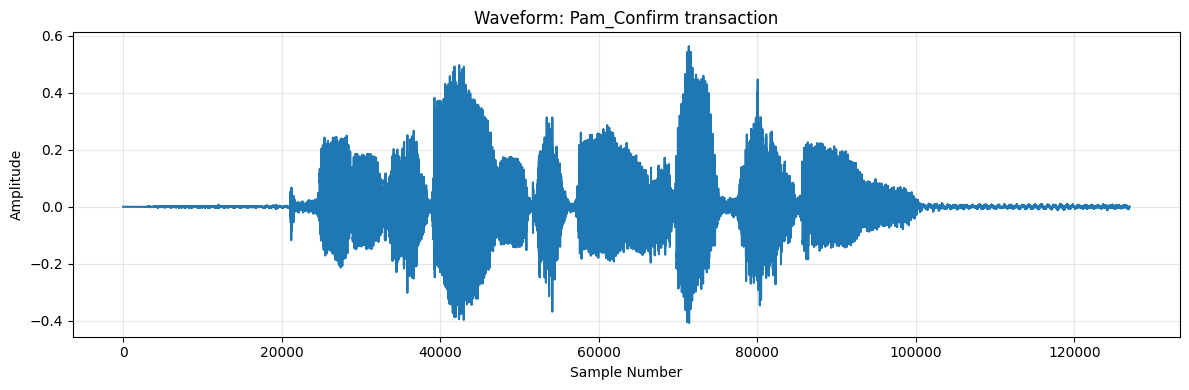

[1/6] Displaying spectrogram for: Pam_Confirm transaction


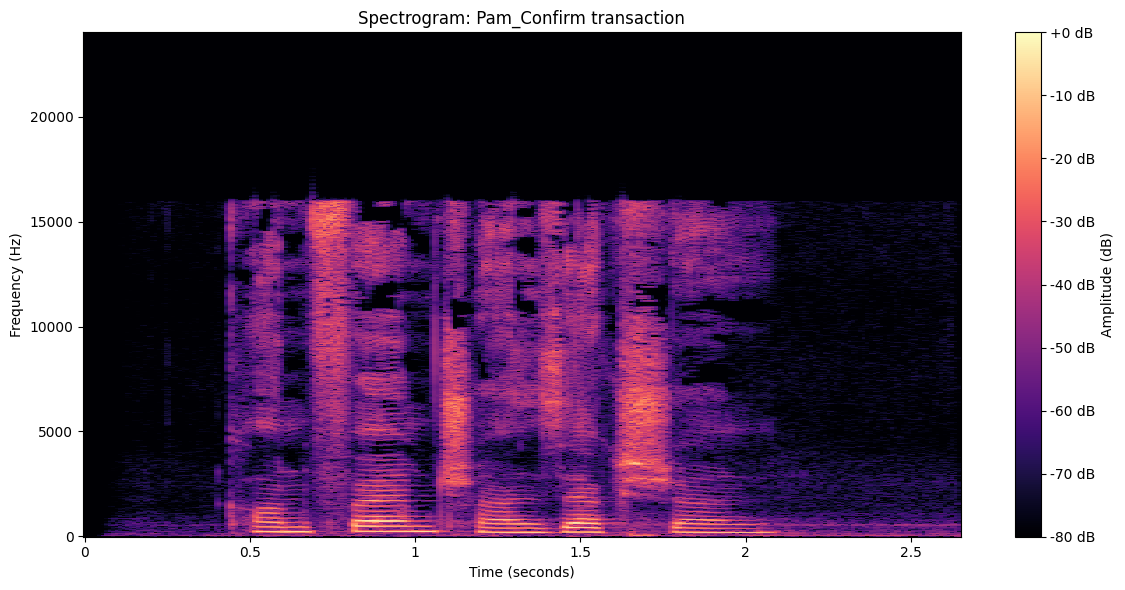

[1/6] Extracting features from original...
[1/6] Applying 8 augmentations...


[1/6]  Completed: 1 original + 8 augmentations = 9 total

PROCESSING FILE 2 of 6: Pam_Yes approve 
Sample rate: 48000 Hz | Duration: 2.30 seconds

[2/6] Displaying waveform for: Pam_Yes approve 


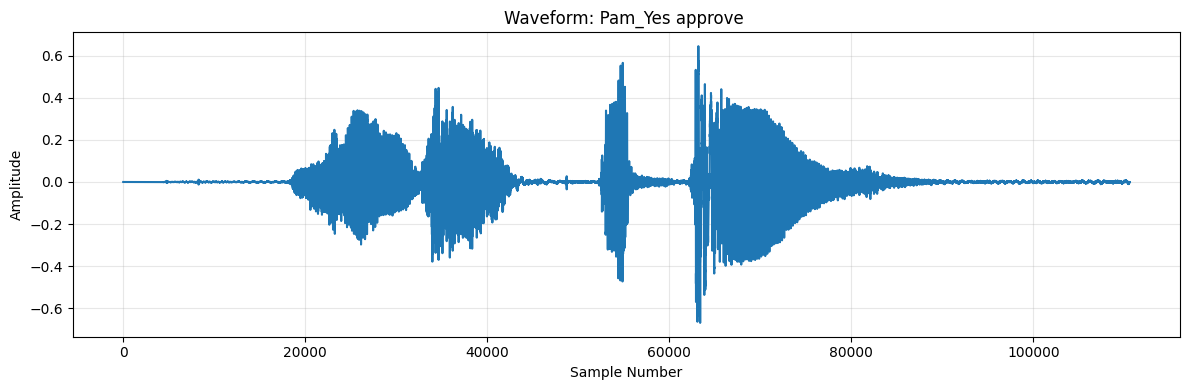

[2/6] Displaying spectrogram for: Pam_Yes approve 


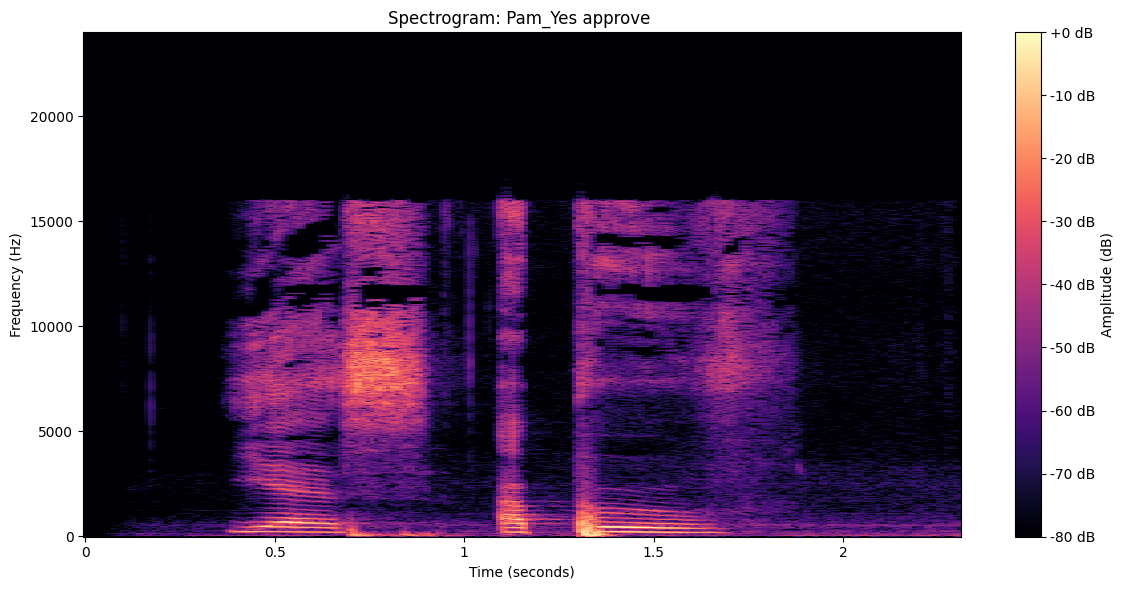

[2/6] Extracting features from original...
[2/6] Applying 8 augmentations...


[2/6]  Completed: 1 original + 8 augmentations = 9 total

PROCESSING FILE 3 of 6: Rele_Recording_1
Sample rate: 48000 Hz | Duration: 1.98 seconds

[3/6] Displaying waveform for: Rele_Recording_1


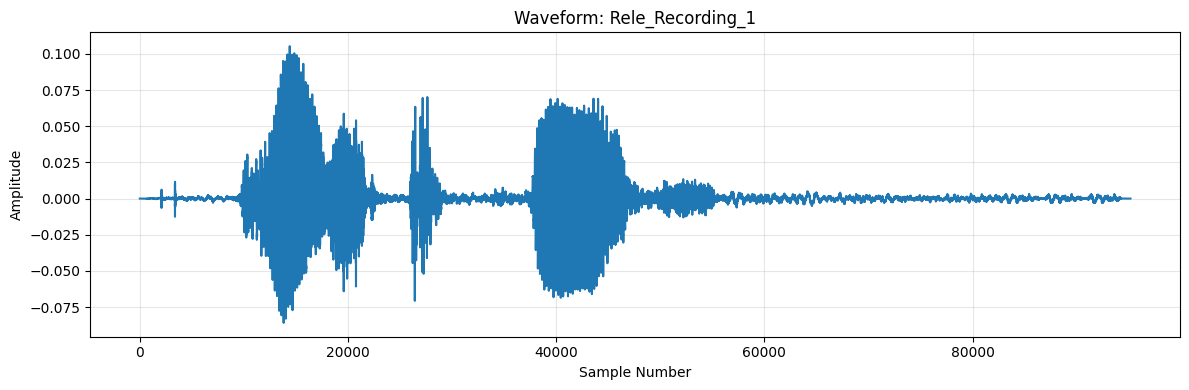

[3/6] Displaying spectrogram for: Rele_Recording_1


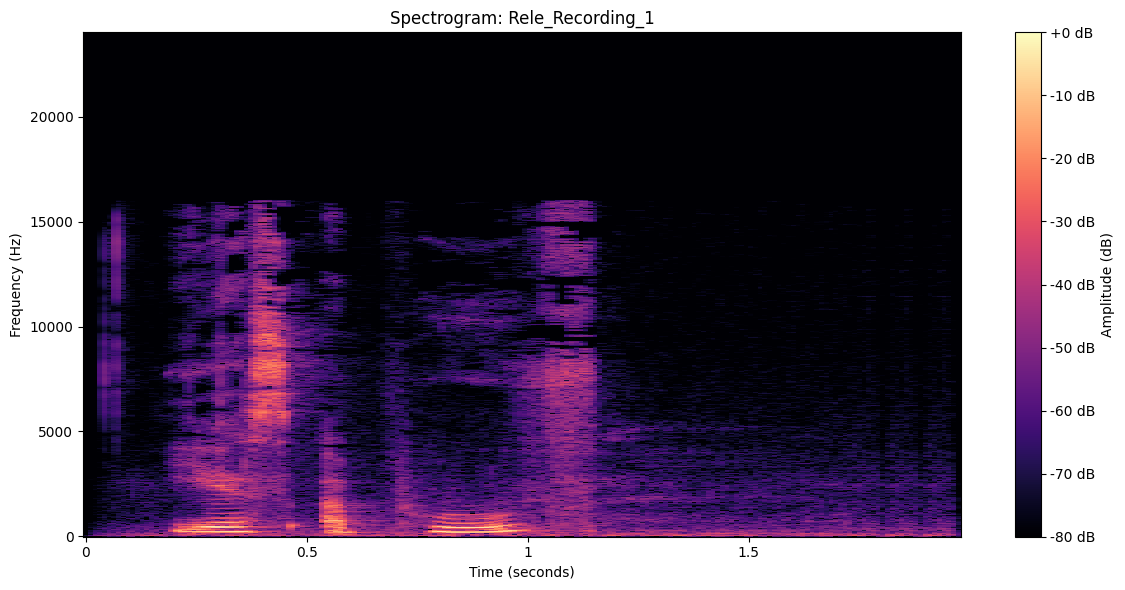

[3/6] Extracting features from original...
[3/6] Applying 8 augmentations...


[3/6]  Completed: 1 original + 8 augmentations = 9 total

PROCESSING FILE 4 of 6: Rele_Recording_2
Sample rate: 48000 Hz | Duration: 3.35 seconds

[4/6] Displaying waveform for: Rele_Recording_2


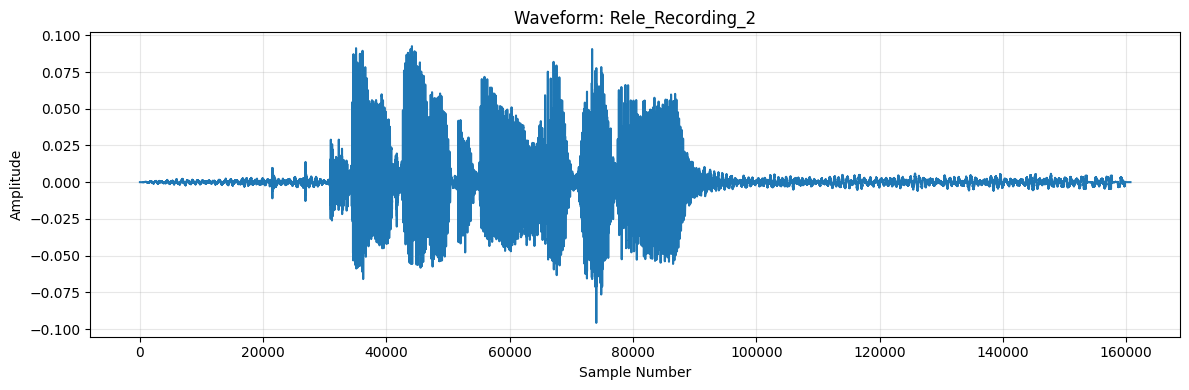

[4/6] Displaying spectrogram for: Rele_Recording_2


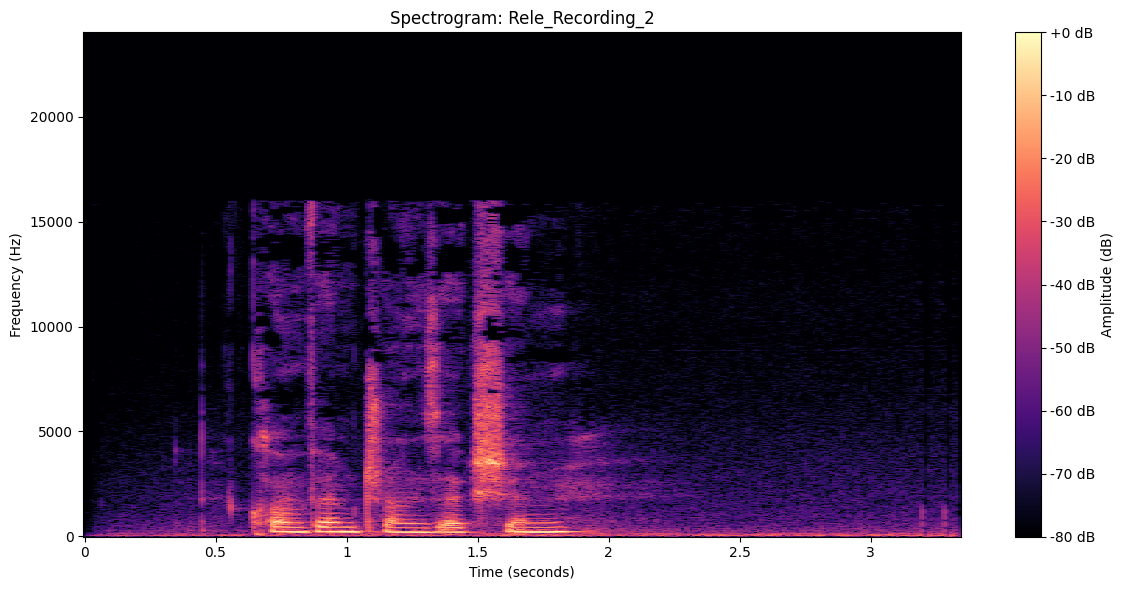

[4/6] Extracting features from original...
[4/6] Applying 8 augmentations...


[4/6]  Completed: 1 original + 8 augmentations = 9 total

PROCESSING FILE 5 of 6: dennis_approve
Sample rate: 48000 Hz | Duration: 1.66 seconds

[5/6] Displaying waveform for: dennis_approve


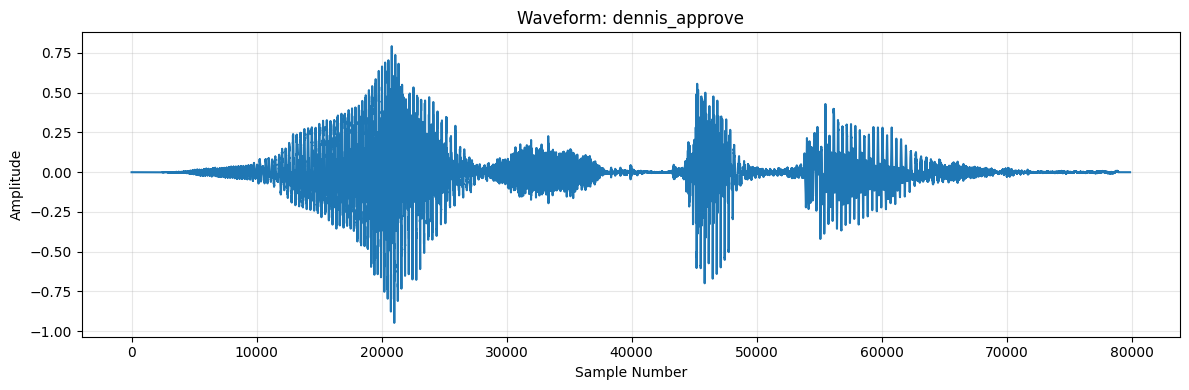

[5/6] Displaying spectrogram for: dennis_approve


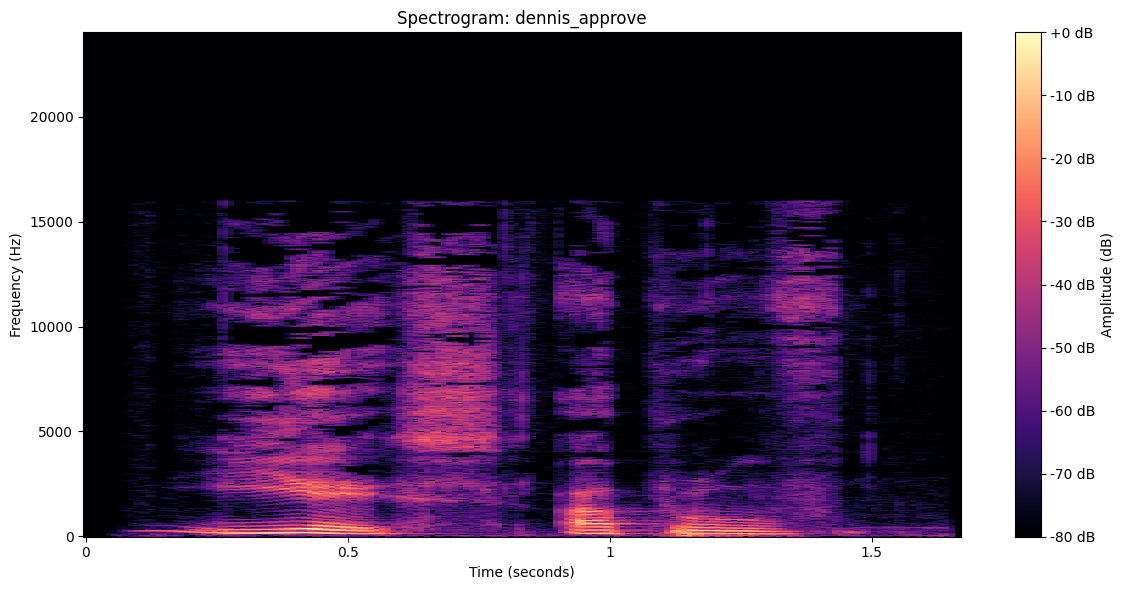

[5/6] Extracting features from original...
[5/6] Applying 8 augmentations...


[5/6]  Completed: 1 original + 8 augmentations = 9 total

PROCESSING FILE 6 of 6: dennis_confirm
Sample rate: 48000 Hz | Duration: 2.26 seconds

[6/6] Displaying waveform for: dennis_confirm


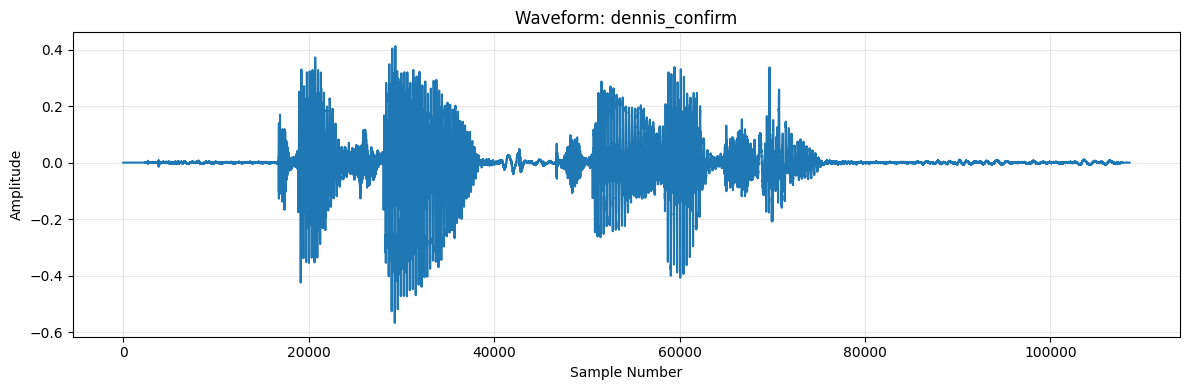

[6/6] Displaying spectrogram for: dennis_confirm


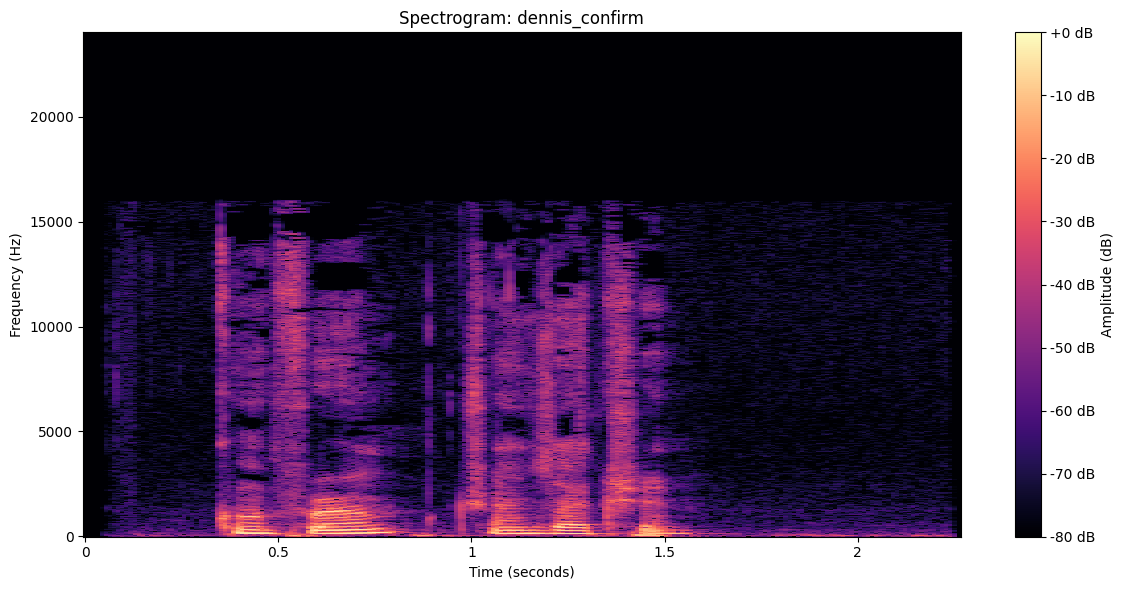

[6/6] Extracting features from original...
[6/6] Applying 8 augmentations...


[6/6]  Completed: 1 original + 8 augmentations = 9 total

SAVING FEATURES TO CSV

Files processed:
  - File 1: Pam_Confirm transaction (Speaker: Pam) - 9 feature vectors
  - File 2: Pam_Yes approve  (Speaker: Pam) - 9 feature vectors
  - File 3: Rele_Recording_1 (Speaker: Rele) - 9 feature vectors
  - File 4: Rele_Recording_2 (Speaker: Rele) - 9 feature vectors
  - File 5: dennis_approve (Speaker: dennis) - 9 feature vectors
  - File 6: dennis_confirm (Speaker: dennis) - 9 feature vectors


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
print("=" * 70)
print("PROCESSING ALL AUDIO FILES")
print("=" * 70)
print("This will process ALL audio files and show visualizations for EACH one")
print("=" * 70)

audio_files = find_audio_files()
if len(audio_files) == 0:
    print("No audio files found! Please run the file loading cell first.")
else:
    print(f"\nFound {len(audio_files)} audio file(s) to process")
    print("Each file will have:")
    print("  - Waveform visualization")
    print("  - Spectrogram visualization")
    print("  - Features extracted (original + 8 augmentations)")
    print()

    augmentations = [
        ('pitch_shift_up', lambda a, s: augment_pitch_shift(a, s, n_steps=2)),
        ('pitch_shift_down', lambda a, s: augment_pitch_shift(a, s, n_steps=-2)),
        ('time_stretch_slow', lambda a, s: augment_time_stretch(a, rate=0.9)),
        ('time_stretch_fast', lambda a, s: augment_time_stretch(a, rate=1.1)),
        ('noise_low', lambda a, s: augment_add_noise(a, noise_factor=0.003)),
        ('noise_high', lambda a, s: augment_add_noise(a, noise_factor=0.01)),
        ('speed_up', lambda a, s: augment_speed_change(a, speed_factor=1.15)),
        ('speed_down', lambda a, s: augment_speed_change(a, speed_factor=0.85))
    ]

    all_features = []

    for idx, audio_file in enumerate(audio_files, 1):
        audio_path = str(audio_file)
        name = audio_file.stem

        print("\n" + "=" * 70)
        print(f"PROCESSING FILE {idx} of {len(audio_files)}: {name}")
        print("=" * 70)

        audio, sr = librosa.load(audio_path, sr=None)
        print(f"Sample rate: {sr} Hz | Duration: {len(audio)/sr:.2f} seconds")

        print(f"\n[{idx}/{len(audio_files)}] Displaying waveform for: {name}")
        plt.figure(figsize=(12, 4))
        pd.Series(audio).plot()
        plt.title(f'Waveform: {name}')
        plt.xlabel('Sample Number')
        plt.ylabel('Amplitude')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        print(f"[{idx}/{len(audio_files)}] Displaying spectrogram for: {name}")
        D = librosa.stft(audio)
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        plt.figure(figsize=(12, 6))
        librosa.display.specshow(S_db, y_axis='hz', x_axis='time', sr=sr)
        plt.colorbar(format='%+2.0f dB', label='Amplitude (dB)')
        plt.title(f'Spectrogram: {name}')
        plt.ylabel('Frequency (Hz)')
        plt.xlabel('Time (seconds)')
        plt.tight_layout()
        plt.show()

        print(f"[{idx}/{len(audio_files)}] Extracting features from original...")
        features = extract_all_features(audio_path)
        features['file_id'] = idx
        features['audio_name'] = name
        features['audio_path'] = audio_path
        features['augmentation'] = 'original'
        speaker = name.split('_')[0] if '_' in name else name.split()[0]
        features['speaker'] = speaker
        all_features.append(features)

        print(f"[{idx}/{len(audio_files)}] Applying {len(augmentations)} augmentations...")
        for aug_name, aug_func in tqdm(augmentations, desc=f"  File {idx} augmentations", leave=False):
            try:
                aug_audio = aug_func(audio.copy(), sr)
                temp_path = f'temp_{name}_{aug_name}.wav'
                sf.write(temp_path, aug_audio, sr)

                aug_features = extract_all_features(temp_path)
                aug_features['file_id'] = idx  # File number (1-6)
                aug_features['audio_name'] = name
                aug_features['audio_path'] = audio_path
                aug_features['augmentation'] = aug_name
                aug_features['speaker'] = speaker
                all_features.append(aug_features)

                if os.path.exists(temp_path):
                    os.remove(temp_path)
            except Exception as e:
                print(f"    Warning: Could not apply {aug_name}: {e}")

        print(f"[{idx}/{len(audio_files)}]  Completed: 1 original + {len(augmentations)} augmentations = {len(augmentations) + 1} total")

    print("\n" + "=" * 70)
    print("SAVING FEATURES TO CSV")
    print("=" * 70)

    if len(all_features) > 0:
        df = pd.DataFrame(all_features)

        feature_cols = [col for col in df.columns if col not in ['file_id', 'speaker', 'audio_name', 'audio_path', 'augmentation']]
        df = df[['file_id', 'speaker', 'audio_name', 'augmentation', 'audio_path'] + feature_cols]

        output_file = 'audio_features.csv'
        df.to_csv(output_file, index=False)


        print(f"\nFiles processed:")
        for name in sorted(df['audio_name'].unique()):
            count = len(df[df['audio_name'] == name])
            speaker = df[df['audio_name'] == name]['speaker'].iloc[0]
            print(f"  - File {df[df['audio_name'] == name]['file_id'].iloc[0]}: {name} (Speaker: {speaker}) - {count} feature vectors")


        try:
            from google.colab import files
            files.download(output_file)
        except ImportError:
            print("google.colab.files not found. Skipping file download.")
        except Exception as e:
            print(f"Error downloading file: {e}")